# Imports, Functions, and EDA

## Imports and Functions

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import zipfile
import glob
from datetime import datetime
import time
from sklearn.preprocessing import normalize

working_directory = '/home/jszou/cs/keenan/'

fluxnet_directory = 'fluxnet/'

all_zip_files = glob.glob(working_directory + fluxnet_directory + "*.zip")

def get_zip_name(site_name, year_range, something):
    return working_directory + fluxnet_directory + 'FLX_' + site_name + '_FLUXNET2015_FULLSET_' \
            + year_range + '_' + something + '.zip'

def who_has_this_column(column_name):
    has_this_column = []
    for f in all_zip_files:
        zf = zipfile.ZipFile(f)
        frame = pd.read_csv(zf.open(zf.namelist()[0]), skiprows=2)
        if column_name in frame.columns.values:
            has_this_column.append(f)
        zf.close()
    return has_this_column

# granularity = 'YY', 'MM', 'WW', 'DD', 'HH' for yearly, monthly, weekly, daily, hourly respectively
def preprocess(site_name, set_type, year_range, something, granularity):
    zf = zipfile.ZipFile(get_zip_name(site_name, year_range, something))
    filename = "FLX_" + site_name + "_FLUXNET2015_" + set_type + "_" + granularity + "_" \
                + year_range + "_" + something + ".csv"
    print('Loading: ' + filename)
    frame = pd.read_csv(zf.open(filename))
    
    print("Total rows: " + str(len(frame.index)))
    print()
    zf.close()
    return frame.astype(np.float32)

# df         | DataFrame | assumed to be preprocessed
# train_prop | double    | proportion of dataset to be used for the training set
def test_train_split(df, train_prop, sequence_length):
    n = len(df.index)
    split_index = int(n*train_prop)
    train_set = df.iloc[:split_index]
    test_set = df.iloc[split_index:]
    return train_set, test_set

## EDA

In [3]:
data = preprocess('CN-Cha', 'FULLSET', '2003-2005', '1-3', 'DD')

Loading: FLX_CN-Cha_FLUXNET2015_FULLSET_DD_2003-2005_1-3.csv
Total rows: 1096



In [4]:
display(data.head(), data.shape)

,TIMESTAMP,TA_F_MDS,TA_F_MDS_QC,TA_F_MDS_NIGHT,TA_F_MDS_NIGHT_SD,TA_F_MDS_NIGHT_QC,TA_F_MDS_DAY,TA_F_MDS_DAY_SD,TA_F_MDS_DAY_QC,TA_ERA,...,GPP_DT_CUT_SE,GPP_DT_CUT_05,GPP_DT_CUT_16,GPP_DT_CUT_25,GPP_DT_CUT_50,GPP_DT_CUT_75,GPP_DT_CUT_84,GPP_DT_CUT_95,RECO_SR,RECO_SR_N
0,20030100.0,-20.586000,1.0,-21.739000,1.741,1.0,-18.664000,1.042,1.0,-21.221001,...,0.005289,0.306852,0.412476,0.412476,0.412476,0.417759,0.420625,0.423614,-9999.0,-9999.0
1,20030102.0,-19.627001,1.0,-20.292999,5.425,1.0,-18.518000,4.286,1.0,-16.701000,...,0.004091,0.225840,0.306388,0.306388,0.306388,0.311613,0.314466,0.317277,-9999.0,-9999.0
2,20030104.0,-16.920000,1.0,-17.948999,3.095,1.0,-15.348000,1.300,1.0,-16.642000,...,0.003518,0.189143,0.257863,0.257863,0.257863,0.262853,0.265588,0.268227,-9999.0,-9999.0
3,20030104.0,-25.042000,1.0,-25.325001,0.516,1.0,-24.608999,0.819,1.0,-24.688999,...,0.003804,0.208826,0.283592,0.283592,0.283592,0.288567,0.291287,0.293954,-9999.0,-9999.0
4,20030104.0,-24.215000,1.0,-24.982000,1.179,1.0,-23.044001,1.746,1.0,-23.971001,...,0.004698,0.265409,0.358534,0.358534,0.358534,0.363935,0.366873,0.369835,-9999.0,-9999.0


(1096, 320)

In [5]:
print([col for col in data.columns if col[-2:] == '_F'])
print(sorted([col for col in data.columns if col[:2] == 'TA']))
print()

['TA_F', 'SW_IN_F', 'LW_IN_F', 'LW_IN_JSB_F', 'VPD_F', 'PA_F', 'P_F', 'WS_F']
['TA_ERA', 'TA_ERA_DAY', 'TA_ERA_DAY_SD', 'TA_ERA_NIGHT', 'TA_ERA_NIGHT_SD', 'TA_F', 'TA_F_DAY', 'TA_F_DAY_QC', 'TA_F_DAY_SD', 'TA_F_MDS', 'TA_F_MDS_DAY', 'TA_F_MDS_DAY_QC', 'TA_F_MDS_DAY_SD', 'TA_F_MDS_NIGHT', 'TA_F_MDS_NIGHT_QC', 'TA_F_MDS_NIGHT_SD', 'TA_F_MDS_QC', 'TA_F_NIGHT', 'TA_F_NIGHT_QC', 'TA_F_NIGHT_SD', 'TA_F_QC']



## Variable Selection

Manual variable selection:

In [6]:
variables = [col for col in data.columns if col[-6:] == '_F_MDS']
variables.remove('CO2_F_MDS')
variables.remove('G_F_MDS')
labels = ['NEE_CUT_USTAR50']
data[variables + labels].head()

,TA_F_MDS,SW_IN_F_MDS,LW_IN_F_MDS,VPD_F_MDS,LE_F_MDS,H_F_MDS,NEE_CUT_USTAR50
0,-20.586000,107.816002,136.929001,0.561,0.610596,17.58120,0.084742
1,-19.627001,78.680000,189.199997,0.616,0.947147,8.93985,0.336581
2,-16.920000,65.601997,221.425003,0.388,3.972680,6.35361,0.336104
3,-25.042000,72.689003,159.460007,0.283,2.235650,15.71080,0.076841
4,-24.215000,92.825996,143.718994,0.347,1.995210,16.58160,0.015102


PCA:

In [9]:
actual_measurements = [col for col in data.columns if ('QC' not in col) 
                       and ('UNC' not in col) and ('METHOD' not in col)
                      and ('SD' not in col) and ('CORR' not in col) 
                       and ('MEAN' not in col) and ('SE' not in col) and ('TIMESTAMP' not in col)
                      and ('NEE' not in col) and ('RECO' not in col)
                      and ('GPP' not in col)]
def pca(df, list_of_variables, k, normalize_matrix=True, choose_by_size=True):
    measurements = df[list_of_variables].to_numpy()
    mu = measurements.mean(0)
    transformed = measurements - mu
    if normalize_matrix:
        transformed = normalize(transformed, axis=0, norm='l1')
    eigenvalues, eigenvectors = np.linalg.eig(np.matmul(transformed.T, transformed))
    if choose_by_size:
        projection_matrix = []
        for i in range(k):
            max_eig = np.argmax(eigenvalues)
            eigenvalues = np.delete(eigenvalues, max_eig)
            projection_matrix.append(eigenvectors[:, max_eig])
            eigenvectors = np.delete(eigenvectors, max_eig, axis=1)
            
        projection_matrix = np.array(projection_matrix).T
    else:
        projection_matrix = eigenvectors[:, 0:k]
    pca_measurements = np.matmul(measurements, projection_matrix)
    return pca_measurements
actual_measurements
#TA, SW, VPD, WS, P, CO2 (missing)
#NEE = net carbon exchange -> use NEE_CUT_REF or NEE_VUT_REF
#GPP = total carbon uptake -> use GPP_DT_VUT_REF or GPP_NT_VUT_REF (or CUT)
#RECO = respiration -> RECO_DT_VUT_REF
#if using DT for one, use DT for another
#focus on GPP first for now
#
#remi prefers VUT
#need remote sensing information
# 
# for input->output, want to predict "current day" accurately based on last x days, dont care the models outputs up
# until current day. 
#
# instant effects: CO2, WS, VPD
# longer-term effects: SW, TA, P
#
# for memory length, try 30 days at most first

# DAYTIME is generated from a model, may not want to use that or compare to both daytime and nighttime

# if not in the site data, just dont use, but should be pretty rare

['TA_F_MDS',
 'TA_F_MDS_NIGHT',
 'TA_F_MDS_DAY',
 'TA_ERA',
 'TA_ERA_NIGHT',
 'TA_ERA_DAY',
 'TA_F',
 'TA_F_NIGHT',
 'TA_F_DAY',
 'SW_IN_POT',
 'SW_IN_F_MDS',
 'SW_IN_ERA',
 'SW_IN_F',
 'LW_IN_F_MDS',
 'LW_IN_ERA',
 'LW_IN_F',
 'LW_IN_JSB',
 'LW_IN_JSB_ERA',
 'LW_IN_JSB_F',
 'VPD_F_MDS',
 'VPD_ERA',
 'VPD_F',
 'PA_ERA',
 'PA_F',
 'P_ERA',
 'P_F',
 'WS_ERA',
 'WS_F',
 'USTAR',
 'NETRAD',
 'CO2_F_MDS',
 'TS_F_MDS_1',
 'SWC_F_MDS_1',
 'G_F_MDS',
 'LE_F_MDS',
 'H_F_MDS',
 'EBC_CF_N',
 'NIGHT_D',
 'DAY_D']

# GAM

# LSTM

## Set up training data

In [138]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import Sampler

class TimeseriesSampler(Sampler):
    """Samples sequences from the dataset using the given window size and step size
        data_source (Dataset): dataset to sample from
    """

    def __init__(self, data_source, window_size=5, step_size=1):
        self.data_source = data_source
        self.windows = []
        for i in range(0, len(data_source)-window_size+1, step_size):
            self.windows.append(list(range(i, i+window_size)))
        
    def __iter__(self):
        return iter(self.windows)

    def __len__(self):
        return len(self.data_source)

sequence_length = 5
split_frac = 0.9

variables = [x for x in actual_measurements if x not in labels]
num_key_variables = 6
processed = pd.DataFrame(pca(data, variables, num_key_variables))
processed[labels] = data[labels]
processed = processed.iloc[0:100]

train, test = test_train_split(processed, split_frac, sequence_length)
train_data = TensorDataset(torch.from_numpy(train.iloc[:, 0:num_key_variables].to_numpy()), torch.from_numpy(train[labels].to_numpy()))
test_data = TensorDataset(torch.from_numpy(test.iloc[:, 0:num_key_variables].to_numpy()), torch.from_numpy(test[labels].to_numpy()))

batch_size = 1

train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, 
                          sampler=TimeseriesSampler(train_data, sequence_length, 1))
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, 
                         sampler=TimeseriesSampler(test_data, sequence_length, 1))

## Set-up model

In [139]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super(SimpleLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.input_size = input_size
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        out = out.view(batch_size, -1)
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

## Training

Epoch: 2/10... Step: 90... Training Loss: 0.028438...
Epoch: 3/10... Step: 180... Training Loss: 0.022954...
Epoch: 4/10... Step: 270... Training Loss: 0.029105...
Epoch: 5/10... Step: 360... Training Loss: 0.016470...
Epoch: 6/10... Step: 450... Training Loss: 0.036278...
Epoch: 7/10... Step: 540... Training Loss: 0.015949...
Epoch: 8/10... Step: 630... Training Loss: 0.025981...
Epoch: 9/10... Step: 720... Training Loss: 0.011198...
Epoch: 10/10... Step: 810... Training Loss: 0.031018...


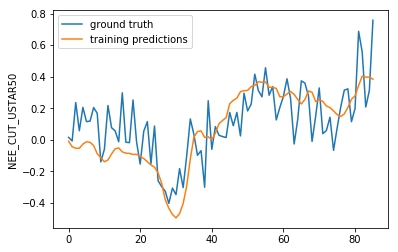

In [143]:
output_size = 1
hidden_dim = 512
n_layers = 2

model = SimpleLSTM(num_key_variables, output_size, hidden_dim, n_layers)
model.to(device)

lr=0.00005
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 10
counter = 0
print_every = 90
clip = 5
# valid_loss_min = np.Inf

model.train()
for i in range(epochs):
    h = model.init_hidden(batch_size)
    
    for inputs, lbls in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, lbls = inputs.to(device), lbls.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), lbls.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Training Loss: {:.6f}...".format(loss.item()))
#             val_h = model.init_hidden(batch_size)
#             val_losses = []
#             model.eval()
#             for inp, lab in val_loader:
#                 val_h = tuple([each.data for each in val_h])
#                 inp, lab = inp.to(device), lab.to(device)
#                 out, val_h = model(inp, val_h)
#                 val_loss = criterion(out.squeeze(), lab.float())
#                 val_losses.append(val_loss.item())
                
#             model.train()
#             print("Epoch: {}/{}...".format(i+1, epochs),
#                   "Step: {}...".format(counter),
#                   "Loss: {:.6f}...".format(loss.item()),
#                   "Val Loss: {:.6f}".format(np.mean(val_losses)))

#             if np.mean(val_losses) <= valid_loss_min:
#                 torch.save(model.state_dict(), './state_dict.pt')
#                 print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
#                 valid_loss_min = np.mean(val_losses)

training_predictions = []
h = model.init_hidden(batch_size)

model.eval()
for x, y in train_loader:
    h = tuple([each.data for each in h])
    x, y = x.to(device), y.to(device)
    output, h = model(x, h)
    output = output[:, -1]
    training_predictions += output.tolist()

x = np.arange(0, 86, 1)
sns.lineplot(x=x, y=train.iloc[4:90][labels[0]], label='ground truth')
sns.lineplot(x=x, y=training_predictions, label='training predictions')
plt.show();

## Testing

In [ ]:
# test_losses = []
# num_correct = 0
# h = model.init_hidden(batch_size)

# model.eval()
# for inputs, labels in test_loader:
#     h = tuple([each.data for each in h])
#     inputs, labels = inputs.to(device), labels.to(device)
#     output, h = model(inputs, h)
#     test_loss = criterion(output.squeeze(), labels.float())
#     test_losses.append(test_loss.item())
#     pred = torch.round(output.squeeze())  # Rounds the output to 0/1
#     correct_tensor = pred.eq(labels.float().view_as(pred))
#     correct = np.squeeze(correct_tensor.cpu().numpy())
#     num_correct += np.sum(correct)

# print("Test loss: {:.3f}".format(np.mean(test_losses)))
# test_acc = num_correct/len(test_loader.dataset)
# print("Test accuracy: {:.3f}%".format(test_acc*100))